# Boilerplate

Package installation, loading, and dataloaders. There's also a simple model defined. You can change it your favourite architecture if you want.

In [1]:
# !pip install tensorboardX

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import time
import matplotlib.pyplot as plt
from torchvision.utils import save_image
from torchvision import datasets, transforms
# from tensorboardX import SummaryWriter

use_cuda = False
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 64

np.random.seed(42)
torch.manual_seed(42)


## Dataloaders
train_dataset = datasets.MNIST('mnist_data/', train=True, download=True, transform=transforms.Compose(
    [transforms.ToTensor()]
))
test_dataset = datasets.MNIST('mnist_data/', train=False, download=True, transform=transforms.Compose(
    [transforms.ToTensor()]
))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Simple NN. You can change this if you want. If you change it, mention the architectural details in your report.
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc = nn.Linear(28*28, 200)
        self.fc2 = nn.Linear(200,10)

    def forward(self, x):
        x = x.view((-1, 28*28))
        x = F.relu(self.fc(x))
        x = self.fc2(x)
        return x

class Normalize(nn.Module):
    def forward(self, x):
        return (x - 0.1307)/0.3081

# Add the data normalization as a first "layer" to the network
# this allows us to search for adverserial examples to the real image, rather than
# to the normalized image
model = nn.Sequential(Normalize(), Net())

model = model.to(device)
model.train()

Sequential(
  (0): Normalize()
  (1): Net(
    (fc): Linear(in_features=784, out_features=200, bias=True)
    (fc2): Linear(in_features=200, out_features=10, bias=True)
  )
)

In [13]:
for batch in train_loader:
    x, y = batch
    print(len(batch))
    print('x.shape : ', x.shape)
    print('y.shape : ', y.shape)

    output = model(x)
    print('output.shape : ', output.shape)
    prediction = output.argmax(dim=1)
    print('prediction.shape : ', prediction.shape)
    correct = (y == prediction).sum().item()
    total = y.size(0)
    print(f'Correctly predicted: {correct} / {total}')

    break

criterion = nn.CrossEntropyLoss()

2
x.shape :  torch.Size([64, 1, 28, 28])
y.shape :  torch.Size([64])
output.shape :  torch.Size([64, 10])
prediction.shape :  torch.Size([64])
Correctly predicted: 8 / 64


# Implement the Attacks

Functions are given a simple useful signature that you can start with. Feel free to extend the signature as you see fit.

You may find it useful to create a 'batched' version of PGD that you can use to create the adversarial attack.

In [3]:
# The last argument 'targeted' can be used to toggle between a targeted and untargeted attack.
def fgsm(model, x, y, eps, targeted=False):
    #TODO: implement this as an intermediate step of PGD
    # Notes: put the model in eval() mode for this function

    model.eval()
    x = x.clone().detach().to(device)
    x.requires_grad = True

    output = model(x)
    loss = criterion(output, y)

    model.zero_grad()
    loss.backward()

    # print('ha')
    gradient = x.grad.data
    sign_gradient = torch.sign(gradient)

    if targeted:
        adv = x - eps * sign_gradient
    else:
        adv = x + eps * sign_gradient
    adv = torch.clamp(adv, 0, 1)

    return adv
    

def pgd_untargeted(model, x, y, k, eps, eps_step):
    #TODO: implement this 
    # Notes: put the model in eval() mode for this function
    # x: input image
    # y: ground truth label for x
    # k: steps of FGSM
    # eps: projection region for PGD (note the need for normalization before projection, as eps values are for inputs in [0,1])
    # eps_step: step for one iteration of FGSM
    model.eval()

    tempt = x.clone().detach()
    tempt.requires_grad = True

    for _ in range(k):
        tempt = fgsm(model, tempt, y, eps_step)
        tempt = torch.clamp(tempt, x - eps, x + eps)
        tempt = torch.clamp(tempt, 0, 1)

    return tempt

# Implement Adversarial Training

In [4]:
def train_model(model, train_loader, num_epochs, enable_defense=True, attack='pgd', eps=0.1, eps_step=0.01, k=10):
    # TODO: implement this function that trains a given model on the MNIST dataset.
    # this is a general-purpose function for both standard training and adversarial training.
    # (toggle enable_defense parameter to switch between training schemes)
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    # optimizer = optim.SGD(model.parameters(), lr=0.001)

    for epoch in range(num_epochs):
        original_losses = []
        original_correct = 0
        original_total = 0
        adversarial_losses = []
        adversarial_correct = 0
        adversarial_total = 0
        for index, batch in enumerate(train_loader):

            # original data
            x, y = batch
            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            
            original_losses.append(loss.item())
            prediction = output.argmax(dim=1)
            original_correct += (y == prediction).sum().item()
            original_total += y.size(0)

            # -------------------------------------------
            
            if enable_defense:
                x, y = batch
                if attack == 'fgsm':
                    adv = fgsm(model, x, y, eps)
                elif attack == 'pgd':
                    adv = pgd_untargeted(model, x, y, k, eps, eps_step)
                

                optimizer.zero_grad()
                output = model(adv)
                # print('output : ', output)
                # print('y : ', y)
                loss = criterion(output, y)
                loss.backward()
                optimizer.step()

                adversarial_losses.append(loss.item())
                prediction = output.argmax(dim=1)
                adversarial_correct += (y == prediction).sum().item()
                adversarial_total += y.size(0)

        print(f'{epoch + 1} loss : {sum(original_losses + adversarial_losses) / len(original_losses + adversarial_losses)}, Accuracy : {(original_correct + adversarial_correct) / (original_total + adversarial_total)}')

In [5]:
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total  = 0

    for index, batch in enumerate(test_loader):
        x, y = batch

        output = model(x)
        prediction = output.argmax(dim=1)
        # print('output.shape : ', output.shape)
        # print('prediction.shape : ', prediction.shape)

        correct += (y == prediction).sum().item()
        total += y.size(0)
    
    accuracy = 100. * correct / total
    # print(f'Test Accuracy : {accuracy:.2f}%')
    return accuracy

def test_model_on_attacks(model, test_loader, attack='pgd', eps=0.1, eps_step=0.01, k=10):
    # TODO: implement this function to test the robust accuracy of the given model
    # use pgd_untargeted() within this function
    model.eval()
    correct = 0
    total  = 0

    for index, batch in enumerate(test_loader):
        x, y = batch

        if attack == 'fgsm':
            adv = fgsm(model, x, y, eps)
        elif attack == 'pgd':
            adv = pgd_untargeted(model, x, y, k, eps, eps_step)
        else:
            adv = x

        

        output = model(adv)
        prediction = output.argmax(dim=1)
        # print('output.shape : ', output.shape)
        # print('prediction.shape : ', prediction.shape)

        correct += (y == prediction).sum().item()
        total += y.size(0)
    
    accuracy = 100. * correct / total
    # print(f'Accuracy under {attack.upper()} attack (eps={eps}): {accuracy:.2f}%')
    return accuracy

# Study Accuracy, Quality, etc.

Compare the various results and report your observations on the submission.

# Problem 1

In [6]:
## train the original model
standard_training_model = nn.Sequential(Normalize(), Net())
standard_training_model = standard_training_model.to(device)
standard_training_model.train()

train_model(standard_training_model, train_loader, 20, False)
torch.save(standard_training_model.state_dict(), 'standard_training_weights.pt')

1 loss : 0.23905898032705986, Accuracy : 0.9282666666666667
2 loss : 0.10033603512973928, Accuracy : 0.96995
3 loss : 0.06849036431426543, Accuracy : 0.9793666666666667
4 loss : 0.051070174979748945, Accuracy : 0.9838666666666667
5 loss : 0.03908441214922017, Accuracy : 0.98725
6 loss : 0.030069047894288124, Accuracy : 0.9900833333333333
7 loss : 0.02574485198264869, Accuracy : 0.9915
8 loss : 0.0218078593239074, Accuracy : 0.9927833333333334
9 loss : 0.016906885621811835, Accuracy : 0.9942166666666666
10 loss : 0.017344459976769113, Accuracy : 0.9939666666666667
11 loss : 0.015821541599720643, Accuracy : 0.9944
12 loss : 0.013219151759669043, Accuracy : 0.9953
13 loss : 0.014561557625624165, Accuracy : 0.9949666666666667
14 loss : 0.01046599839265642, Accuracy : 0.9965666666666667
15 loss : 0.010500290336188402, Accuracy : 0.9968166666666667
16 loss : 0.010800080451645044, Accuracy : 0.9964
17 loss : 0.010844431493202673, Accuracy : 0.9963333333333333
18 loss : 0.011033730781030806, A

In [7]:
## PGD attack
# model = nn.Sequential(Normalize(), Net())
# model.load_state_dict(torch.load('weights.pt'))

standard_accuracy = test_model(standard_training_model, test_loader)
print(f'Standard Accuracy : ', standard_accuracy)
print()

for eps in [0.05, 0.1, 0.15, 0.2]:
    standard_accuracy = test_model(standard_training_model, test_loader)
    adversarial_accuracy = test_model_on_attacks(standard_training_model, test_loader, attack='pgd', eps=eps)
    print(f'Adversarial Accuracy (eps={eps}) : ', adversarial_accuracy)
    print(f'Robust Accuracy (eps={eps}) : {(standard_accuracy + adversarial_accuracy) / 2}')
    print()

Standard Accuracy :  97.74

Adversarial Accuracy (eps=0.05) :  71.08
Robust Accuracy (eps=0.05) : 84.41

Adversarial Accuracy (eps=0.1) :  29.46
Robust Accuracy (eps=0.1) : 63.599999999999994

Adversarial Accuracy (eps=0.15) :  29.46
Robust Accuracy (eps=0.15) : 63.599999999999994

Adversarial Accuracy (eps=0.2) :  29.46
Robust Accuracy (eps=0.2) : 63.599999999999994



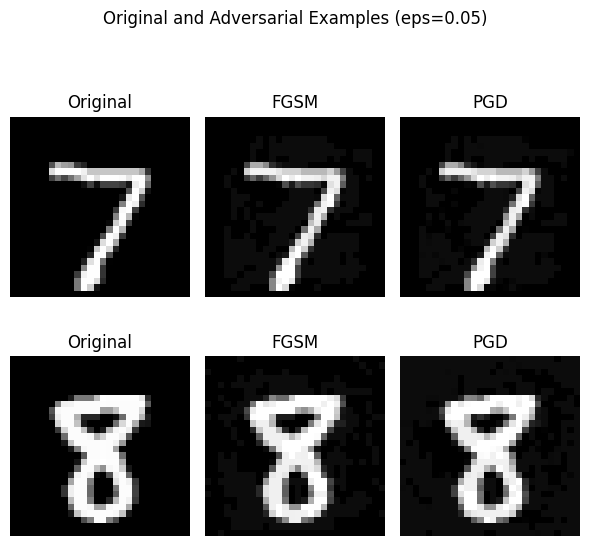

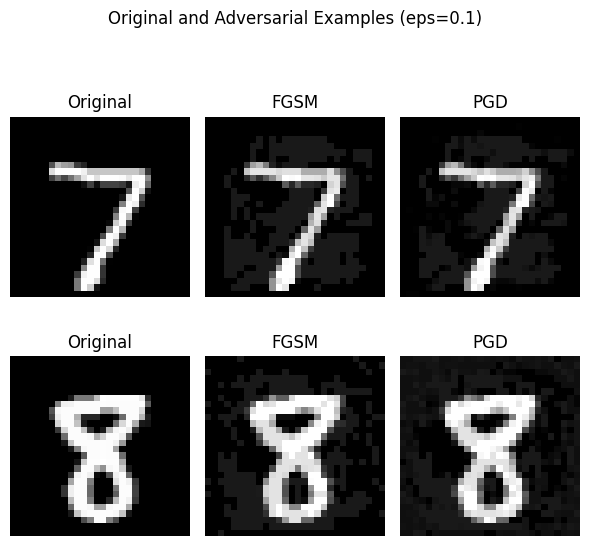

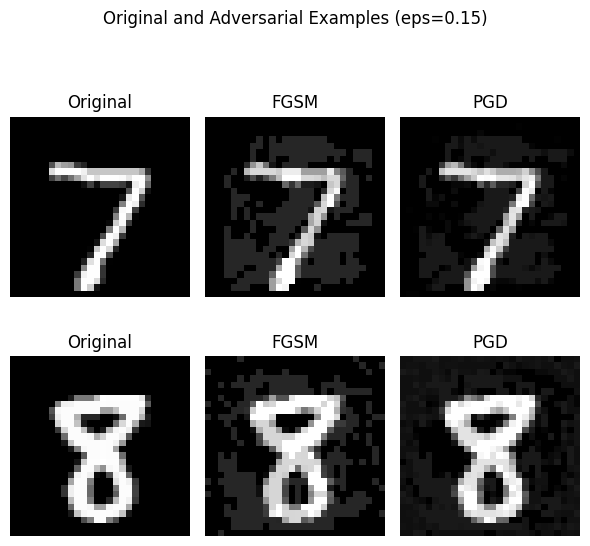

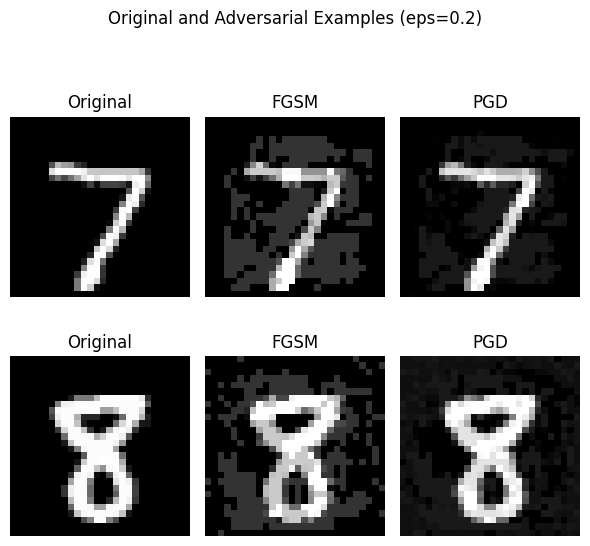

In [8]:
def plot_adversarial_examples(model, data_loader, eps, n_examples=2):
    model.eval()
    
    fig, axs = plt.subplots(nrows=n_examples, ncols=3, figsize=(6, 3 * n_examples))
    fig.suptitle(f'Original and Adversarial Examples (eps={eps})')

    count = 0

    for index, (x, y) in enumerate(data_loader):
        if index % 2 != 0:
            continue
        if count >= n_examples:
            break
        x, y = x.to(device), y.to(device)

        original_image = x[0].unsqueeze(0)
        target = y[0].unsqueeze(0)
        
        fgsm_image = fgsm(model, original_image, target, eps)
        eps_step = 0.01
        k = 10
        pgd_image = pgd_untargeted(model, original_image, target, k, eps, eps_step)
        
        axs[count, 0].imshow(original_image.cpu().detach().numpy().squeeze(), cmap='gray')
        axs[count, 0].set_title('Original')
        axs[count, 0].axis('off')
        
        axs[count, 1].imshow(fgsm_image.cpu().detach().numpy().squeeze(), cmap='gray')
        axs[count, 1].set_title('FGSM')
        axs[count, 1].axis('off')

        axs[count, 2].imshow(pgd_image.cpu().detach().numpy().squeeze(), cmap='gray')
        axs[count, 2].set_title('PGD')
        axs[count, 2].axis('off')

        count += 1

    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.show()

for eps in [0.05, 0.1, 0.15, 0.2]:
    plot_adversarial_examples(standard_training_model, test_loader, eps)

# Problem 2

In [9]:
## PGD based adversarial training
eps = 0.1
adversarial_training_model = nn.Sequential(Normalize(), Net())
train_model(adversarial_training_model, train_loader, 20, True, 'pgd', eps)
# torch.save(adversarial_training_model.state_dict(), f'adversarial_training_weights_AT_{eps}.pt')

1 loss : 0.44939482596063457, Accuracy : 0.8507583333333333
2 loss : 0.2827610367859926, Accuracy : 0.9067083333333333
3 loss : 0.25358089580680176, Accuracy : 0.917075
4 loss : 0.23423477156938655, Accuracy : 0.9232166666666667
5 loss : 0.2238830815275152, Accuracy : 0.92585
6 loss : 0.21368045564234528, Accuracy : 0.929
7 loss : 0.20846612212665902, Accuracy : 0.9309166666666666
8 loss : 0.2027356050555348, Accuracy : 0.93235
9 loss : 0.19899717073213422, Accuracy : 0.9332916666666666
10 loss : 0.1944471302791995, Accuracy : 0.9351083333333333
11 loss : 0.1909157535756133, Accuracy : 0.9364
12 loss : 0.18847415947844573, Accuracy : 0.9376333333333333
13 loss : 0.18649029173952927, Accuracy : 0.938325
14 loss : 0.18342541286504385, Accuracy : 0.9386333333333333
15 loss : 0.17961347755475982, Accuracy : 0.9401333333333334
16 loss : 0.179405039889699, Accuracy : 0.940325
17 loss : 0.17709784989707794, Accuracy : 0.9410333333333334
18 loss : 0.17674050105007505, Accuracy : 0.941941666666

In [10]:
## PGD attack
# model = nn.Sequential(Normalize(), Net())
# model.load_state_dict(torch.load(f'weights_AT_{eps}.pt'))

standard_accuracy = test_model(adversarial_training_model, test_loader)
print(f'Standard Accuracy (eps={eps}) : ', standard_accuracy)
print()

for eps in [0.05, 0.1, 0.15, 0.2]:
    pgd_adversarial_accuracy = test_model_on_attacks(adversarial_training_model, test_loader, attack='pgd', eps=eps)
    fgsm_adversarial_accuracy = test_model_on_attacks(adversarial_training_model, test_loader, attack='fgsm', eps=eps)
    print(f'PGD Adversarial Accuracy (eps={eps}) : ', pgd_adversarial_accuracy)
    print(f'FGSM Adversarial Accuracy (eps={eps}) : ', fgsm_adversarial_accuracy)
    print(f'Robust Accuracy (eps={eps}) : {(standard_accuracy + pgd_adversarial_accuracy) / 2}')
    print()

Standard Accuracy (eps=0.1) :  98.43

PGD Adversarial Accuracy (eps=0.05) :  95.01
FGSM Adversarial Accuracy (eps=0.05) :  95.32
Robust Accuracy (eps=0.05) : 96.72

PGD Adversarial Accuracy (eps=0.1) :  87.16
FGSM Adversarial Accuracy (eps=0.1) :  89.23
Robust Accuracy (eps=0.1) : 92.795

PGD Adversarial Accuracy (eps=0.15) :  87.16
FGSM Adversarial Accuracy (eps=0.15) :  78.13
Robust Accuracy (eps=0.15) : 92.795

PGD Adversarial Accuracy (eps=0.2) :  87.16
FGSM Adversarial Accuracy (eps=0.2) :  60.96
Robust Accuracy (eps=0.2) : 92.795



In [11]:
## PGD based adversarial training
eps = 0.1
fgsm_model = nn.Sequential(Normalize(), Net())
train_model(fgsm_model, train_loader, 20, True, 'fgsm', eps)
# torch.save(fgsm_model.state_dict(), f'adversarial_training_weights_AT_{eps}.pt')

1 loss : 0.43184506574244513, Accuracy : 0.858325
2 loss : 0.2677692845071565, Accuracy : 0.9126833333333333
3 loss : 0.23365506869807803, Accuracy : 0.9246083333333334
4 loss : 0.2145881250649363, Accuracy : 0.9295
5 loss : 0.2023220270033628, Accuracy : 0.9337333333333333
6 loss : 0.19286790185906827, Accuracy : 0.9363083333333333
7 loss : 0.18550646168106957, Accuracy : 0.9391333333333334
8 loss : 0.17980222290467177, Accuracy : 0.9409583333333333
9 loss : 0.17771146612488595, Accuracy : 0.942125
10 loss : 0.17036012288265878, Accuracy : 0.9436916666666667
11 loss : 0.16787922193774016, Accuracy : 0.9445083333333333
12 loss : 0.16505002746573721, Accuracy : 0.9455333333333333
13 loss : 0.1635342970042294, Accuracy : 0.9467833333333333
14 loss : 0.16062554966637008, Accuracy : 0.9467
15 loss : 0.15842801822946212, Accuracy : 0.94775
16 loss : 0.15599423260337722, Accuracy : 0.9481083333333333
17 loss : 0.1551529607432249, Accuracy : 0.9487666666666666
18 loss : 0.15326527152721808, A

In [12]:
standard_accuracy = test_model(fgsm_model, test_loader)
print(f'Standard Accuracy (eps={eps}) : ', standard_accuracy)
print()

for eps in [0.05, 0.1, 0.15, 0.2]:
    pgd_adversarial_accuracy = test_model_on_attacks(fgsm_model, test_loader, attack='pgd', eps=eps)
    fgsm_adversarial_accuracy = test_model_on_attacks(fgsm_model, test_loader, attack='fgsm', eps=eps)
    print(f'PGD Adversarial Accuracy (eps={eps}) : ', pgd_adversarial_accuracy)
    print(f'FGSM Adversarial Accuracy (eps={eps}) : ', fgsm_adversarial_accuracy)
    print(f'Robust Accuracy (eps={eps}) : {(standard_accuracy + pgd_adversarial_accuracy) / 2}')
    print()

Standard Accuracy (eps=0.1) :  98.52

PGD Adversarial Accuracy (eps=0.05) :  94.81
FGSM Adversarial Accuracy (eps=0.05) :  95.14
Robust Accuracy (eps=0.05) : 96.66499999999999

PGD Adversarial Accuracy (eps=0.1) :  85.94
FGSM Adversarial Accuracy (eps=0.1) :  88.3
Robust Accuracy (eps=0.1) : 92.22999999999999

PGD Adversarial Accuracy (eps=0.15) :  85.94
FGSM Adversarial Accuracy (eps=0.15) :  75.79
Robust Accuracy (eps=0.15) : 92.22999999999999

PGD Adversarial Accuracy (eps=0.2) :  85.94
FGSM Adversarial Accuracy (eps=0.2) :  56.99
Robust Accuracy (eps=0.2) : 92.22999999999999

